<a href="https://colab.research.google.com/github/jakobatgithub/unreverb/blob/main/ConvolutionAndDeconvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rir_generator

  Created wheel for rir-generator: filename=rir_generator-0.1.0-cp37-cp37m-linux_x86_64.whl size=29981 sha256=6bec93aa799a0aa02ff01c8e72bd212496dbcf18577281d0246cddf8372d6358
  Stored in directory: /root/.cache/pip/wheels/f2/b8/44/24e3838f71aebbd5ce66bce52ffa435649fbb723a4e85544bc
Successfully built rir-generator


In [2]:
import numpy as np
import scipy.signal as ss
import soundfile as sf
import rir_generator as rir
from IPython.display import Audio 
from IPython.core.display import display
import matplotlib.pyplot as plt

# A script to generate the Impulse Response (IR) Functions of a rectangular room
# of a given size with given receiver and source positions and given Reverberation time T60.

# https://github.com/audiolabs/rir-generator
# pip install rir-generator
# pip install SoundFile

#signal, fs = sf.read("bark.wav", always_2d=True)

def my_convolution(IR_data, signal):
  # be careful with the order of IR_data and signal!
  #return ss.convolve(IR_data, signal, mode='full')
  #return ss.convolve(signal, IR_data, mode='same')
	return ss.convolve(signal, IR_data, mode='valid')
 
def render_history(history):
    plt.plot(history["loss"], label="loss")
    #plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

#samplerate = 2**13
samplerate = 2**9

#reverberation_times = [0.4, 0.6, 0.8]
reverberation_times = [0.8]
IR_datas = []
idx = 0
for reverberation_time in reverberation_times:
    IR_data = rir.generate(
    	c=340,                  # Sound velocity (m/s)
    	fs=samplerate,                  # Sample frequency (samples/s)
    	r=[                     # Receiver position(s) [x y z] (m)
    	    [4.5, 2.5, 1.5]
    	],
    	s=[0.5, 2.5, 1.5],          # Source position [x y z] (m)
    	L=[5, 5, 3],            # Room dimensions [x y z] (m)
    	reverberation_time=reverberation_time, # Reverberation time T60 (s)
    	nsample=samplerate,           # Number of output samples
	)
    print(IR_data.shape)              # (4096, 3)
    IR_datas.append(IR_data)
    #sf.write('random_IRs/IRF_'+str(idx)+'.wav', IR_data, samplerate)
    idx = idx +1	

#print(signal.shape)         # (11462, 2)

# Convolve 2-channel signal with 3 impulse responses
#signal = ss.convolve(h[:, None, :], signal[:, :, None])

#print(signal.shape)         # (15557, 2, 3)

(512, 1)


In [3]:
N = 2*samplerate
batch = 10000
split = batch
IR_data = IR_datas[0].T[0]
signal = np.random.randn(batch*N)
signals = np.array(np.array_split(signal, split))
transformed_signals = []
for signal in signals:
  transformed_signal = my_convolution(IR_data, signal)
  transformed_signals.append(transformed_signal)

transformed_signals = np.array(transformed_signals)
print(signal.shape)
print(signals.shape)
print(transformed_signal.shape)
print(transformed_signals.shape)
display(Audio(np.array(signals[0]), rate=samplerate, autoplay=False))
display(Audio(np.array(transformed_signals[0]), rate=samplerate, autoplay=False))

(1024,)
(10000, 1024)
(513,)
(10000, 513)


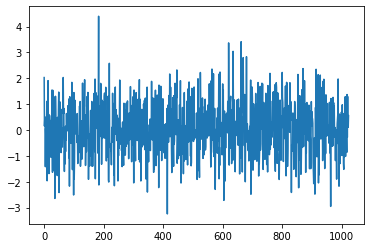

In [4]:
plt.plot(signals[0])
plt.show()

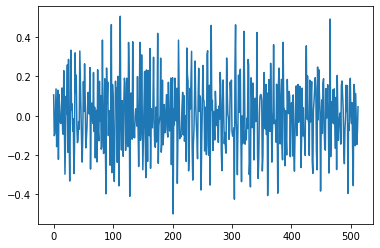

In [5]:
plt.plot(transformed_signals[0])
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 513)               525312    
                                                                 
Total params: 525,312
Trainable params: 525,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
100/100 [==============================] - 3s 2ms/step - loss: 0.6507
Epoch 2/35
100/100 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 3/35
100/100 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 4/35
100/100 [==============================] - 0s 2ms/step - loss: 2.5334e-04
Epoch 5/35
100/100 [==============================] - 0s 2ms/step - loss: 9.7680e-06
Epoch 6/35
100/100 [==============================] - 0s 2ms/step - loss: 2.5245e-07
Epoch 7/35
100/100 [==============================] - 0s 2ms/step - loss: 4.1917

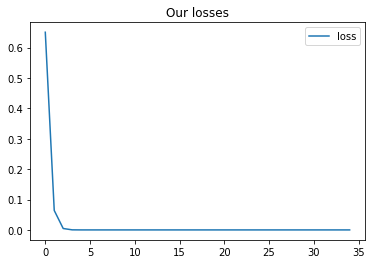

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Convolution1D

X = signals
y = transformed_signals

# Create model with no hidden layers, same number of outputs as inputs.
# No bias needed.  No activation function, 
# since DFT is linear.
model = Sequential([Dense(y.shape[1], input_dim=X.shape[1], use_bias=False, activation=None)])
#model = Sequential([Convolution1D(N, kernel_size=N, padding='causal', input_shape=(None, 256), dilation_rate=1, use_bias=False, activation=None)])
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, y, epochs=35, batch_size=100, verbose='auto')
print(f"history.history['loss'][-1]: {history.history['loss'][-1]}")
render_history(history.history)

In [7]:
datas = np.random.randn(2,N)
transformed_datas = []
for data in datas:
  transformed_data = my_convolution(IR_data, data)
  transformed_datas.append(transformed_data)

prediction = model.predict(datas)
print(f'Convolution matches NN: {np.allclose(prediction, transformed_datas, rtol=1e-02)}')

Convolution matches NN: False


In [8]:
prediction - transformed_datas

array([[-1.61332783e-07,  1.21925466e-07, -1.13527672e-07, ...,
         2.28799852e-08,  5.36053949e-08,  6.91730756e-08],
       [ 1.00830163e-07, -1.59214119e-07, -1.65054405e-07, ...,
        -1.16927255e-07, -5.38485310e-08, -5.06826298e-08]])

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# load data
# paths of the tensorflow datasets
path = '/content/drive/My Drive/dsr_project/data/HarvardWordList/'

# load and concatenate the tensorflow datasets
dataset = tf.data.experimental.load(path + "tf_randomIRFs_dataset")
# determine size of the dataset
dataset_size = sum(1 for _ in dataset)
print(f"dataset_size: {dataset_size}")

def lambda_1(features, labels, targets):
  return (features, labels)

def lambda_2(features, labels, targets):
  return (features, targets)

def lambda_3(features, labels, targets):
  return labels

# obtain the datasets containing only labels or targets
label_dataset = dataset.map(lambda features, labels, targets: lambda_1(features, labels, targets))
target_dataset = dataset.map(lambda features, labels, targets: lambda_2(features, labels, targets))

# obtain all labels
all_labels = dataset.map(lambda features, labels, targets: lambda_3(features, labels, targets))

# transform all_labels dataset to numpy array
all_labels_np = []
for label in all_labels:
  all_labels_np.append(tfds.as_numpy(label))

all_labels_np = np.array(all_labels_np)

# determine unique labels
unique_labels, counts = np.unique(all_labels_np, return_counts=True)
print(f"unique_labels: {unique_labels}")
#print(counts)

# determine number of unique labels
nr_of_unique_labels = unique_labels.shape[0]
print(f"nr_of_unique_labels: {nr_of_unique_labels}")

# shuffle the dataset before splitting in train and validate!
label_dataset = label_dataset.shuffle(dataset_size)

# split dataset in train and validate
train_fraction = 0.8
validate_dataset_size = int(dataset_size * (1.0-train_fraction)) # 20 percent of dataset_size
train_dataset = label_dataset.skip(validate_dataset_size)
validate_dataset = label_dataset.take(validate_dataset_size)

dataset_size: 740
unique_labels: [0 1 2 3 4 5 6 7 8 9]
nr_of_unique_labels: 10


In [18]:
for features, targets in target_dataset.take(1):
  signal = targets.numpy()

In [19]:
ss.convolve(signal, IR_data, mode='same')

(1, 64000)